In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Change default colours to personal colour scheme
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["indianred", "cornflowerblue", "mediumseagreen", "plum", "sandybrown"]) 

rootPath = r"/home/daraghhollman/Main/UCD_PASS_Labs/RamsauerTownsend/Data"

def LoadFile(path, skiprows=2):
    data = np.array(np.loadtxt(path, skiprows=skiprows))
    return data

In [2]:
def Current(voltage, resistance):
    return voltage / resistance

In [35]:
def ExtractData(data, uncertainnty=False):
    inputVoltage = data[:,0]
    plateCurrent = [Current(el/10000, 10000) for el in data[:,1]] # note conversion from milivolts to volts
    shieldCurrent = [Current(el/10000, 100) for el in data[:,2]]    

    if uncertainnty:
        plateCurrentUncertainty = [Current(0.05/1000, 10000) for el in data[:,3]]  
        return [inputVoltage, plateCurrent, shieldCurrent, plateCurrentUncertainty]
    else:
        return [inputVoltage, plateCurrent, shieldCurrent]

(0.0, 2e-06)

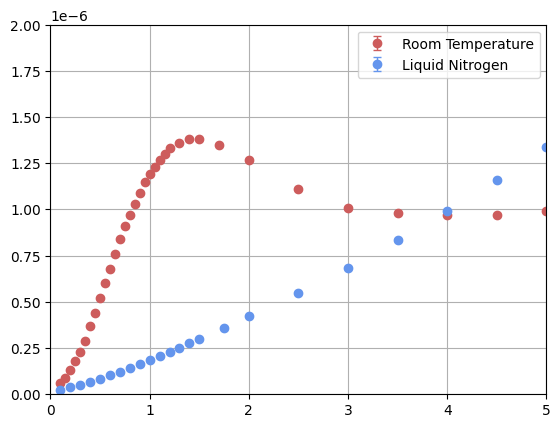

In [36]:
warmData = ExtractData(LoadFile(rootPath + r"/warmData.txt")[0:-6], uncertainnty=True)

coldData = ExtractData(LoadFile(rootPath + r"/coldData.txt")[0:-6], uncertainnty=False)

plt.errorbar(warmData[0], [el*10 for el in warmData[1]], yerr=warmData[3], fmt="o", capsize=3, linewidth=1, label="Room Temperature")
plt.errorbar(coldData[0], coldData[1], yerr=Current(0.05/1000, 10000), fmt="o", capsize=3, linewidth=1, label="Liquid Nitrogen")

plt.legend()
plt.grid()
plt.xlim(0, 5)
plt.ylim(0, 2e-6)